In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from keras.models import model_from_json
from keras.optimizers import RMSprop 

import json
import csv

In [2]:
notes_model_file   = 'data/results/note_model_180114.json'
notes_weights_file = 'data/results/note_mask_weights_180114_120637.h5'
with open(notes_model_file,"r") as f:
    json_string = f.read()
notes_model = model_from_json(json_string)
notes_model.load_weights(notes_weights_file)

In [3]:
length_model_file   = 'data/results/length_model_180114.json'
length_weights_file = 'data/results/length_mask_weights_180114_120637.h5'
with open(length_model_file,"r") as f:
    json_string = f.read()
length_model = model_from_json(json_string)
length_model.load_weights(length_weights_file)

In [71]:
def get_notes(base_name):
    notes = []
    with open(f'../setup/{base_name}.rmf') as csvfile:
        for row in csv.reader(csvfile):
            if row[0] == 'note':
                notes.append(row[1:])  
    return notes

def get_notes_lengths(note_pred,length_pred):
    assert(note_pred.shape[0] == length_pred.shape[0])
    num_preds = note_pred.shape[0]
    notes_lengths = []
    for i in range(num_preds):
        note_class = note_pred[i].argmax()
        length_class = length_pred[i].argmax()
        note_confidence = note_pred[i,note_class]
        #if note_confidence > 0.99:
        #    note_confidence = "high"
        #elif note_confidence > 0.8:
        #    note_confidence = "med"
        #else:
        #    note_confidence = "low"
        note_index = note_class-2
        note_name = "C C# D D# E F F# G G# A A# B".split()[note_index % 12]
        note_octave = int(note_index/12) - 2
        if note_index == -2:
            note_name = 'X'
            note_octave = 0
        elif note_index == -1:
            note_name = 'R'
            note_octave = 0
        length_confidence = length_pred[i,length_class]
        #if length_confidence > 0.99:
        #    length_confidence = "high"
        #elif length_confidence > 0.8:
        #    length_confidence = "med"
        #else:
        #    length_confidence = "low"
        length = length_class/4
        if note_index == -2 and note_confidence > 0.8:#note_confidence != "low":
            continue # no note
        notes_lengths.append([i,
                              (note_index,note_name,note_octave,note_confidence),
                              (length, length_confidence)])
    return notes_lengths

def find_best_sample(cur):
    num_samples = len(cur)
    if num_samples > 0:
        conf = np.zeros(num_samples)
        for i,c in enumerate(cur):
            conf[i] = c[0][-1]
        mci = conf.argmax()
        return (cur[mci][0][0],cur[mci][1][0])
    return (None, None)

def refine_notes_lengths(raw_notes_lengths):
    notes_lengths = []
    cur = []
    last_index = -100
    for x in raw_notes_lengths:
        if x[0] == last_index + 1:
            cur.append(x[1:])
        else:
            (n,l) = find_best_sample(cur)
            if n:
                notes_lengths.append((n,l))
            cur = []
        last_index = x[0]
    (n, l) = find_best_sample(cur)
    if n:
        notes_lengths.append((n,l))
    return notes_lengths

def get_crop_inputs(cur_score_info):
    img_crop_width = 32
    img_step = 2
    img_crop_height = int(cur_score_info['height'])
    img_count = cur_score_info['width']//img_step
    cur_img = Image.open('data/train2/' + cur_score_info['name'])
    cur_crop_inputs = np.zeros((img_count,img_crop_height,img_crop_width,1),dtype='uint8')
    for i in range(img_count):
        img_x = i*img_step
        cur_crop_img = cur_img.crop((img_x, 0, img_x + img_crop_width, img_crop_height))
        cur_crop_inputs[i] = np.array(cur_crop_img).reshape(img_crop_height,img_crop_width,1)
    return cur_crop_inputs 

# FIXME output to file
def output_rmf(outfile,notes_lengths):
    print("writing output to:",outfile)
    with open(outfile,'w') as f:
        cur_beat = 0.0
        #print(notes_lengths)
        for (n,l) in notes_lengths:
            print("note,%d,%f,%f"%(n,cur_beat,l),file=f)
            cur_beat += l


In [72]:
with open(f"data/train2/strip_score_info.json", 'r') as infile:
    score_info = json.load(infile)
    
last_base_name = ""
score_notes_lengths = {}
target_notes_lengths = {}
for cur_score_info in score_info:
    print(cur_score_info['name'])
    cur_base_name = cur_score_info['base']
    if cur_base_name != last_base_name:
        if len(score_notes_lengths.get(last_base_name,[])) > 0:
            rmf_filename = "data/results/%s.rmf"%(last_base_name)
            output_rmf(rmf_filename,score_notes_lengths[last_base_name]) # FIXME
        score_notes_lengths[cur_base_name] = []
        target_notes_lengths[cur_base_name] = get_notes(cur_base_name)
        last_base_name = cur_base_name
    cur_crop_inputs = get_crop_inputs(cur_score_info)
    # predict
    note_preds   = notes_model.predict(cur_crop_inputs)
    length_preds = length_model.predict(cur_crop_inputs)
    raw = get_notes_lengths(note_preds,length_preds)
    nl = refine_notes_lengths(raw)
    #print("x",nl)
    score_notes_lengths[cur_base_name].extend(nl)
rmf_filename = "data/results/%s.rmf"%(last_base_name)
output_rmf(rmf_filename,score_notes_lengths[last_base_name])

strip_score_chromatic_00.png
strip_score_gen_one_00.png
writing output to: data/results/chromatic.rmf
strip_score_gen_one_01.png
strip_score_gen_one_02.png
strip_score_gen_one_03.png
strip_score_gen_one_04.png
strip_score_gen_one_05.png
strip_score_gen_one_06.png
strip_score_gen_one_07.png
strip_score_gen_two_00.png
writing output to: data/results/gen_one.rmf
strip_score_gen_two_01.png
strip_score_gen_two_02.png
strip_score_gen_two_03.png
strip_score_gen_two_04.png
strip_score_gen_two_05.png
strip_score_gen_two_06.png
strip_score_gen_two_07.png
strip_score_gen_two_08.png
strip_score_gen_two_09.png
strip_score_gen_two_10.png
strip_score_gen_two_11.png
strip_score_twinkle_00.png
writing output to: data/results/gen_two.rmf
strip_score_twinkle_01.png
writing output to: data/results/twinkle.rmf


In [62]:
# Debug below here

In [73]:
cur_score_info = score_info[0]
cur_crop_inputs = get_crop_inputs(cur_score_info)
note_preds = notes_model.predict(cur_crop_inputs)
length_preds = length_model.predict(cur_crop_inputs)
raw = get_notes_lengths(note_preds,length_preds)
nl = refine_notes_lengths(raw)

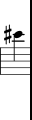

In [74]:
I=-15#41#-31 # -15
Image.fromarray(cur_crop_inputs[I].reshape(120,32))

In [75]:
i = note_preds[I].argmax()
i-2,note_preds[I][i]

(85, 0.99539113)

In [76]:
i = length_preds[I].argmax()
i/4,length_preds[I][i]

(1.0, 0.99975854)

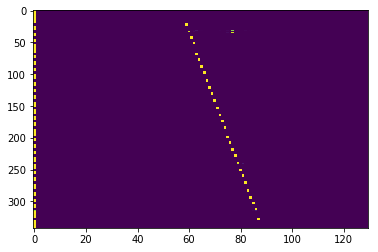

In [77]:
plt.imshow(note_preds, aspect='auto')

In [78]:
raw

[[21, (57, 'A', 2, 0.99964261), (1.0, 0.99990356)],
 [22, (57, 'A', 2, 0.99994445), (1.0, 0.99999785)],
 [23, (57, 'A', 2, 0.99993217), (1.0, 0.99981505)],
 [24, (57, 'A', 2, 0.99992454), (1.0, 0.99999249)],
 [32, (75, 'D#', 4, 0.81811202), (1.0, 0.99365306)],
 [33, (58, 'A#', 2, 0.93456286), (1.0, 0.99997592)],
 [34, (75, 'D#', 4, 0.9044168), (1.0, 0.99978298)],
 [35, (75, 'D#', 4, 0.94055599), (1.0, 0.99898773)],
 [41, (59, 'B', 2, 0.9969843), (1.0, 0.99998605)],
 [42, (59, 'B', 2, 0.99852705), (1.0, 0.99999845)],
 [43, (59, 'B', 2, 0.99814856), (1.0, 0.99999905)],
 [44, (59, 'B', 2, 0.98962295), (1.0, 0.99999511)],
 [50, (60, 'C', 3, 0.99683458), (1.0, 0.9999994)],
 [51, (60, 'C', 3, 0.99993277), (1.0, 1.0)],
 [52, (60, 'C', 3, 0.99979943), (1.0, 1.0)],
 [53, (60, 'C', 3, 0.99999785), (1.0, 1.0)],
 [67, (61, 'C#', 3, 0.99999356), (1.0, 0.99999499)],
 [68, (61, 'C#', 3, 0.99999654), (1.0, 1.0)],
 [69, (61, 'C#', 3, 0.99999845), (1.0, 0.99999905)],
 [70, (61, 'C#', 3, 0.99999571), (1.

In [79]:
nl

[(57, 1.0),
 (75, 1.0),
 (59, 1.0),
 (60, 1.0),
 (61, 1.0),
 (62, 1.0),
 (63, 1.0),
 (64, 1.0),
 (65, 1.0),
 (66, 1.0),
 (67, 1.0),
 (68, 1.0),
 (69, 1.0),
 (70, 1.0),
 (71, 1.0),
 (72, 1.0),
 (73, 1.0),
 (74, 1.0),
 (75, 1.0),
 (76, 1.0),
 (77, 1.0),
 (78, 1.0),
 (79, 1.0),
 (80, 1.0),
 (81, 1.0),
 (82, 1.0),
 (83, 1.0),
 (84, 1.0),
 (85, 1.0)]